# Prepping EOF calculation

Do an EOF calculation of 
- SST
- upper OHC (0-50m)
- MLD (Mar for NH)
and compare the patterns. 

Is there a mode that resembles the multidecadal variability we see in the time series? Does the mld pattern resemble the SST pattern? If so, it could be a sign that it is driven by too large convection in the model which we might fix with changing parameters. 

Comparison between SST and uOHC: SST is very much influenced by the atmosphere whereas the uOHC (to 50m) will highlight the ocean.

Use annual averages (or March value for mld) for the NA basin. At a later stage, extend to the entire globe and compare if the modes change. For the comparison between SST/uOHC and mld, the NA should be enough and is faster for now...

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

import eofs
from eofs.xarray import Eof
import scipy
import xrft

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46845/status,
Dashboard: /proxy/46845/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41745,Workers: 7
Dashboard: /proxy/46845/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:44975,Total threads: 4
Dashboard: /proxy/41017/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:39925,


In [3]:
# Data
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

path_SST  = path_to_data + 'SST_global_annual.nc'
path_uohc = path_to_data + 'uohc_annual.nc'
path_mld  = path_to_data + 'mld_Mar_NA.nc'

In [4]:
# Plotting info
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

ft_size = 16
plt.rcParams.update({'font.size': ft_size})

### Import data

In [5]:
lon_slice = slice(-75,-7)
lat_slice = slice(25,70)

In [6]:
uohc = xr.open_dataarray(path_uohc)
uohc = uohc.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)

In [7]:
uohc = uohc.rename({'year': 'time'})
uohc

<xarray.DataArray 'uohc' (time: 499, yt_ocean: 290, xt_ocean: 272)>
[39361120 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -74.88 -74.62 -74.38 ... -7.625 -7.375 -7.125
  * yt_ocean  (yt_ocean) float64 25.04 25.26 25.49 25.72 ... 69.78 69.88 69.99
  * time      (time) int64 1 2 3 4 5 6 7 8 9 ... 492 493 494 495 496 497 498 499
Attributes:
    long_name:  Upper ocean heat content; depth-integrated from 50m to 0m
    units:      Joules meters**-2

In [8]:
mld = xr.open_dataarray(path_mld)
mld

<xarray.DataArray 'mld' (time: 499, yt_ocean: 290, xt_ocean: 272)>
[39361120 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -74.88 -74.62 -74.38 ... -7.625 -7.375 -7.125
  * yt_ocean  (yt_ocean) float64 25.04 25.26 25.49 25.72 ... 69.78 69.88 69.99
  * time      (time) object 0001-03-16 12:00:00 ... 0499-03-16 12:00:00
Attributes:
    long_name:      mixed layer depth determined by density criteria
    units:          m
    valid_range:    [      0. 1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    ncfiles:        ['/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/o...
    contact:        Martin Dix
    email:          martin.dix@csiro.au
    created:        2021-11-30
    description:    ACCESS-CM2 with n96 atmosphere coupled to COSIMA OM2 0.25...
    url:            https://code.metoffice.gov.uk/svn/roses-u/c/j/8/7/7/trunk

In [15]:
sst = xr.open_dataarray(path_SST)
sst = sst.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)
sst

<xarray.DataArray 'temp' (time: 499, yt_ocean: 290, xt_ocean: 272)>
[39361120 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -74.88 -74.62 -74.38 ... -7.625 -7.375 -7.125
  * yt_ocean  (yt_ocean) float64 25.04 25.26 25.49 25.72 ... 69.78 69.88 69.99
    st_ocean  float64 ...
  * time      (time) object 0001-12-31 00:00:00 ... 0499-12-31 00:00:00

### EOF

In [11]:
def do_eof_analysis(da, n_eofs):
    """Performs EOF analysis of dataarray `da` and returns the first `n_eofs` (Int) EOFs and PCAs.
    Note that the `eofs` package require the `da` is defined on a regular longitude-latitude grid. """
    
    da_nomean = da - da.mean(dim='time')
    
    coslat = np.cos(np.deg2rad(da.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    
    solver = Eof(da, weights=wgts)

    eof = solver.eofsAsCovariance(neofs=n_eofs)

    pca = solver.pcs(npcs=n_eofs, pcscaling=1)
    
    variance_fraction = solver.varianceFraction(neigs=n_eofs)
    
    variance_fraction_error = solver.northTest(neigs=n_eofs, vfscaled=True)
    
    total_variance = solver.totalAnomalyVariance()

    return eof, pca, variance_fraction, variance_fraction_error, total_variance

In [17]:
# eof wants longitude latitude grid
uohc = uohc.rename({'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})
mld  = mld.rename({'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})
sst  = sst.rename({'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})

#### uOHC

In [18]:
%%time
eof1, pc1, varianceFraction1, varianceFractionError1, total_variance1 = do_eof_analysis(uohc, n_eofs=10)

CPU times: user 16.7 s, sys: 20.3 s, total: 37.1 s
Wall time: 35.4 s


Principal component time series

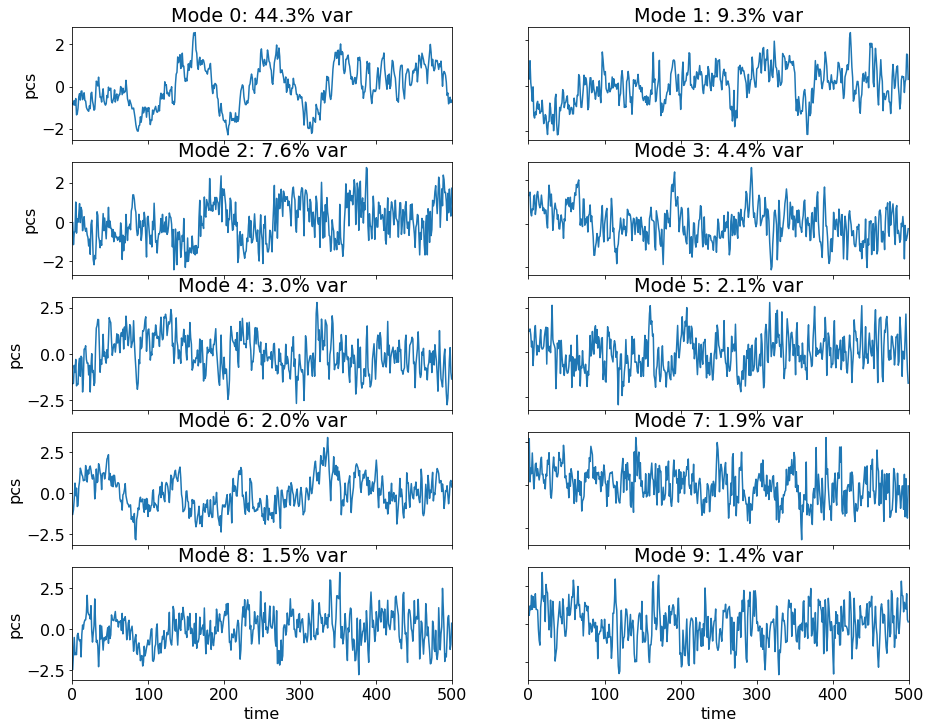

In [46]:
fig = plt.figure(figsize=(15,12))

for ii in range(10):
    plt.subplot(5,2,ii+1)
    pc1[:,ii].plot()
    plt.xlim(0, 500)
    if ii < 8:
        plt.tick_params(labelbottom=False)
        plt.xlabel('')
    if (ii % 2) != 0:
        plt.tick_params(labelleft=False)
        plt.ylabel('')
    title_name = 'Mode ' + str(ii) + ': ' + str(np.round(varianceFraction1[ii].values * 100, 1)) + '% var'
    plt.title(title_name)#, loc='left')

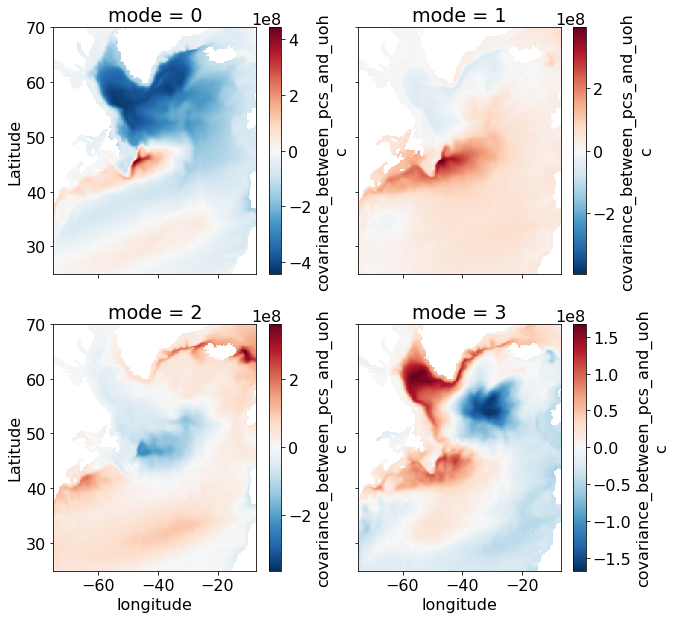

In [53]:
fig = plt.figure(figsize=(10,10))

for ii in range(4):
    plt.subplot(2,2,ii+1)
    eof1[ii,:,:].plot()
    if ii in (1, 3):
        plt.tick_params(labelleft=False)
        plt.ylabel('')
    else:
        plt.ylabel('Latitude')
    if ii < 2:
        plt.tick_params(labelbottom=False)
        plt.xlabel('')
    else:
        plt.xlabel('Longitude')

#### MLD

In [19]:
%%time
eof2, pc2, varianceFraction2, varianceFractionError2, total_variance2 = do_eof_analysis(mld, n_eofs=10)

CPU times: user 15.8 s, sys: 1.18 s, total: 17 s
Wall time: 16.2 s


Principal component time series

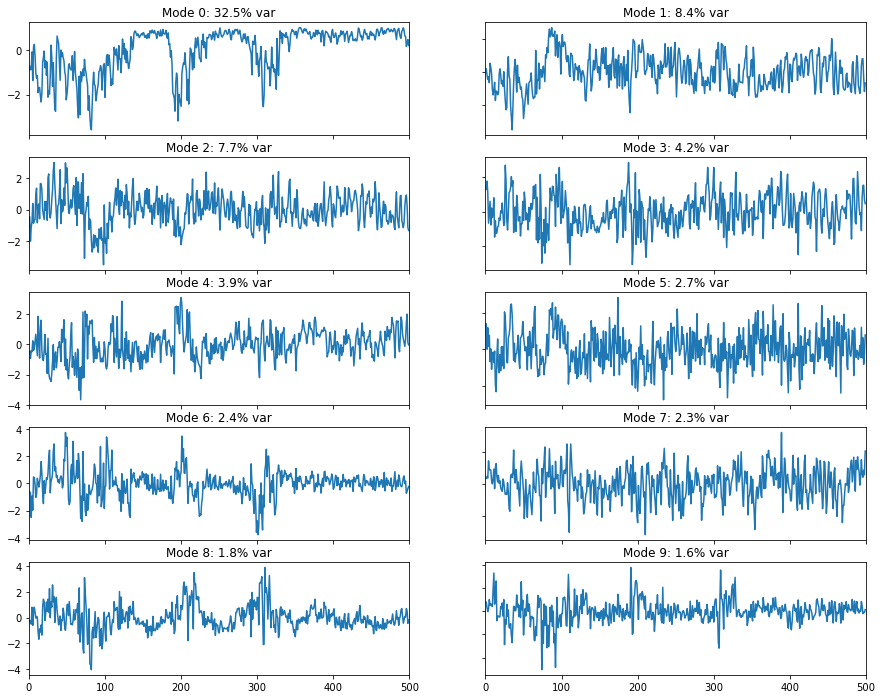

In [94]:
fig = plt.figure(figsize=(15,12))

for ii in range(10):
    plt.subplot(5,2,ii+1)
    plt.plot(pc1.time, pc2[:,ii])
    plt.xlim(0, 500)
    if ii < 8:
        plt.tick_params(labelbottom=False)
        plt.xlabel('')
    if (ii % 2) != 0:
        plt.tick_params(labelleft=False)
        plt.ylabel('')
    title_name = 'Mode ' + str(ii) + ': ' + str(np.round(varianceFraction2[ii].values * 100, 1)) + '% var'
    plt.title(title_name)#, loc='left')

In [88]:
years = np.arange(0, 500, 1)

In [93]:
pc1

<xarray.DataArray 'pcs' (time: 499, mode: 10)>
array([[-0.80508332,  0.36474991, -0.03657283, ...,  2.68093632,
        -2.44319158,  0.47238866],
       [-0.86759505,  1.35426409, -1.15083468, ...,  0.1808079 ,
        -1.45236473,  0.96626193],
       [-0.6673809 ,  0.15513055, -0.52342967, ...,  0.98055473,
        -0.502861  ,  0.76027637],
       ...,
       [-0.50987824,  1.71500319,  0.89808269, ..., -1.64695493,
        -1.23135311,  1.61922063],
       [-0.76229297,  1.6922452 ,  0.29835318, ..., -1.91754505,
        -0.92635675,  0.23100347],
       [-0.65778612,  0.33915816,  1.70955143, ..., -0.05510487,
         0.36494795,  0.1175559 ]])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 ... 492 493 494 495 496 497 498 499
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9

### SST

In [20]:
%%time
eof3, pc3, varianceFraction3, varianceFractionError3, total_variance3 = do_eof_analysis(sst, n_eofs=10)

CPU times: user 10.9 s, sys: 2.11 s, total: 13 s
Wall time: 14.1 s


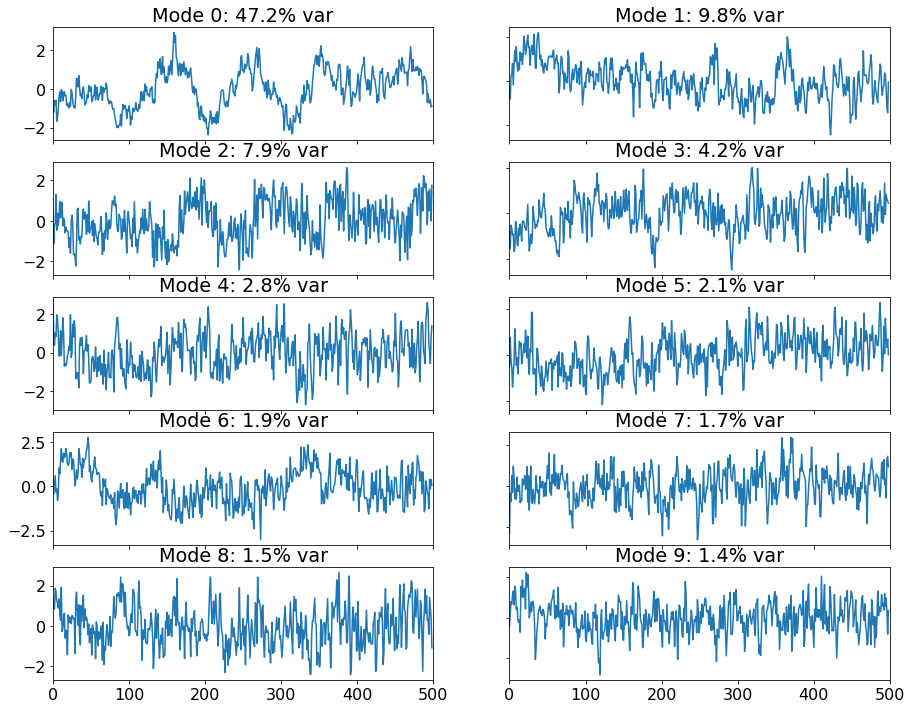

In [21]:
fig = plt.figure(figsize=(15,12))

for ii in range(10):
    plt.subplot(5,2,ii+1)
    plt.plot(pc3[:,ii])
    plt.xlim(0, 500)
    if ii < 8:
        plt.tick_params(labelbottom=False)
        plt.xlabel('')
    if (ii % 2) != 0:
        plt.tick_params(labelleft=False)
        plt.ylabel('')
    title_name = 'Mode ' + str(ii) + ': ' + str(np.round(varianceFraction3[ii].values * 100, 1)) + '% var'
    plt.title(title_name)#, loc='left')

### Compare PC time series to amo-index (based on SST)

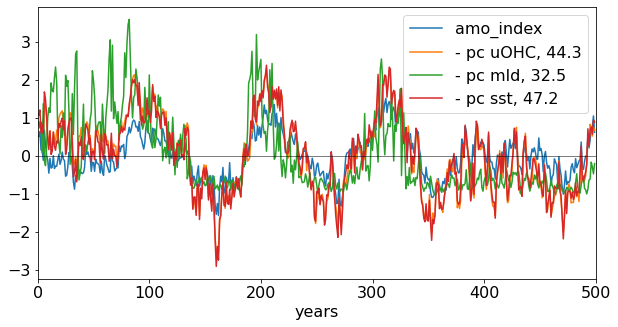

In [37]:
amo_index = xr.open_dataarray(path_to_data + 'amo_index.nc')

fig = plt.figure(figsize=(10,5))
plt.plot(pc1.time, amo_index, label='amo_index')
plt.plot(pc1.time, -1*pc1[:,0], label='- pc uOHC, %.1f'%(np.round(varianceFraction1[0].values * 100, 1)))
plt.plot(pc1.time, -1*pc2[:,0], label='- pc mld, %.1f'%(np.round(varianceFraction2[0].values * 100, 1)))
plt.plot(pc1.time, -1*pc3[:,0], label='- pc sst, %.1f'%(np.round(varianceFraction3[0].values * 100, 1)))
plt.legend()
plt.axhline(0, color='k', linewidth=0.5)
plt.xlim(0, 500)
plt.xlabel('years')


# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_pc_timeseries_NA.png'
    plt.savefig(fig_path + fig_name);